<a href="https://colab.research.google.com/github/dmburt/BayesianInference/blob/main/notebooks/switchpoint/Switchpoint_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Switchpoint Modeling
_Updated and tested for Google Colab Mar. 21, 2025_
<br><br>
When analyzing data, it's common to start with methods that capture trends over time, like linear regression. These approaches are useful, but they often fall short when the key question isn't simply about whether a trend exists—but **why** that trend might have changed at a certain point.

Consider a classic example of coal-mining disasters in Britain. At first glance, you might look at the data and ask, "How are the number of disasters changing over time?" But what if you suspect that an important event—say, a change in safety regulations or the introduction of new mining practices—led to a dramatic decrease in these disasters? The real challenge becomes not estimating the overall trend, but identifying **when** this change occurred. Knowing the timing of such a switch could point us toward the underlying causes.

This is where **switchpoint modeling** comes in.

## What Is a Switchpoint Model?

A switchpoint model is designed to detect a point (or points) in time where the behavior of a data series changes significantly. Instead of assuming that the data follows a uniform trend across the entire time period, the model allows for a “switch” where the parameters of the process—like the rate of disasters or the average level of some outcome—change abruptly.

For example, in the coal-mining disaster data:
- **Before the switchpoint:** The number of disasters might follow one rate, influenced by earlier safety practices.
- **After the switchpoint:** A new safety policy or regulation might have reduced the disaster rate to a lower level.

By estimating the timing of the switch, we gain valuable insight into when these changes likely took effect, which is crucial for identifying possible causal factors such as legislative reforms or industry shifts.

## A Look Toward Health Economics

While the coal-mining disaster example provides a clear and historical case, similar ideas apply to health economics. Suppose you’re analyzing data on healthcare utilization or costs. Instead of simply modeling an upward or downward trend, you might be more interested in identifying the moment when a major policy was implemented—say, a new reimbursement rule or an introduction of managed care—that changed the trajectory of healthcare metrics.

By employing switchpoint modeling:
- You can detect the change point in healthcare outcomes.
- You can then investigate external factors (policy changes, market dynamics) that could have driven this change.
- This approach provides a more nuanced understanding of cause and effect than traditional trend models.

## In Summary

Switchpoint modeling moves us beyond the question of "What is the trend?" to ask "When did a significant change occur, and why might that have happened?" This perspective is crucial for making informed decisions and policies, whether we're looking at industrial safety records or the impacts of health policies.

In the following sections of this notebook, we’ll start with the coal-mining disaster data to illustrate the principles of switchpoint modeling. Later, we’ll explore a health economics example—using either real or synthetic data—to demonstrate how these ideas apply in your field. By the end of this exploration, you’ll see how switching from simple trend analysis to models that account for structural changes can uncover deeper insights about the systems you’re studying.


In [1]:
# Local pip installs for libraries
!pip install pymc watermark;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00


In [2]:
import pymc as pm
#from pymc_extras.model.marginal.marginal_model import MarginalModel
import pandas as pd
import numpy as np
import arviz as az
import seaborn as sns
#import nutpie
import datetime
import watermark

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams

from IPython import display
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def set_style():
    font = {'family' : 'Liberation Sans',
            #'size'   : 16
           }
    math_fontfamily = {'family' : 'Liberation Sans',
                      }
    plt.style.use(['seaborn-v0_8-whitegrid', 'seaborn-v0_8-paper'])

set_style()


rcParams["mathtext.fontset"] = 'custom'
rcParams["mathtext.rm"] = 'Liberation Sans'
rcParams["mathtext.it"] = 'Liberation Sans'
rcParams["mathtext.sf"] = 'Liberation Sans'
rcParams['font.cursive'] = 'Liberation Sans'

%config InlineBackend.figure_format = 'svg'   # saves image formats in vector graphics (sharper, scalable graphics)

## Coal-mining disasters: the data

In [3]:
# TODO: Try to handle np.nan
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
     3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
     2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
     1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
     0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
     3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
     0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on

years = np.arange(1851, 1962)
disaster_data.index = years

df = pd.DataFrame(disaster_data)
df=df.reset_index()
df.columns=['Year','Disasters']



## Visualizing the Data with a Trend Line

Before diving into switchpoint modeling, let's take a moment to explore the data using a familiar approach—a simple trend line. In the cell below, you'll see a plot of the coal-mining disaster data with a trend line fitted to the entire time series.

At first glance, this visualization might lead you to focus on whether the overall number of disasters is increasing or decreasing over time. This trend-line approach is a standard method from regression analysis and provides a quick snapshot of the data's direction and amount of change over that time.

However, while trend lines are useful for summarizing the general behavior of the data, they can mask critical shifts in the underlying process. For instance, if there's a sudden change in the disaster rate—perhaps due to new safety regulations or industrial practices—a single trend line may fail to capture that abrupt transition. In other words, trend lines help answer the "what" but not the "when" or "why."

This observation sets the stage for **switchpoint modeling**. Instead of smoothing over the data to reveal a continuous trend, switchpoint models allow us to narrow in on that period when a significant change occurred. This, in turn, opens up opportunities to investigate potential causes behind that change—-what happened at that time?  Was there a policy intervention, a technological advancement, or some other known external factor that occurred then?

Take a look at the trend line visualization below. Notice how it presents a clear overall trend. We get the data to for the trend from the Seaborn `lmplot()` best-fit line and calculate the slope of that line using Numpy's `polyfit()` function.

Next, we'll build on this insight to estimate the period in time when the behavior of the system appears to shift, paving the way for a deeper causal analysis.


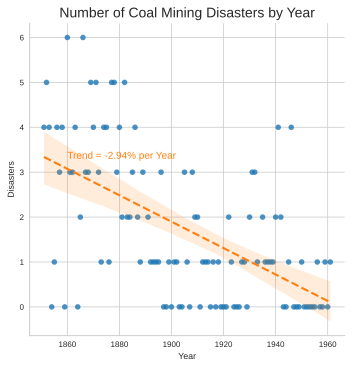

In [4]:
g = sns.lmplot(data=df, x='Year', y='Disasters',
               line_kws={'linestyle': '--',
                         'color':'C1'
                        })
plt.title('Number of Coal Mining Disasters by Year', size=14)

# Calculate trend from lmplot data
ax = g.axes[0, 0]
line = ax.lines[0]
x_data, y_data = line.get_data()
slope, intercept = np.polyfit(x_data, y_data, 1)
plt.text(y=3.3, x=1860, s=f'Trend = {slope*100:.2f}% per Year', color='C1')

sns.despine()

## Why Move Beyond Simple Trend Models?

Traditional regression models can tell you whether there’s an upward or downward trend, but they don’t directly address questions of *change*. Specifically:
- **Trend models assume continuity:** They smooth over abrupt changes and may miss the real-world impact of a sudden event.
- **Causal insights are obscured:** Without knowing when a change occurred, it’s difficult to link the timing to potential causes like new policies, economic shifts, or other interventions.

Switchpoint models let us:
- **Isolate the moment of change:** Estimate when the system’s behavior shifted, and use the power of statistical techniques to put a credible interval around that estimate.
- **Inform further investigation:** Once you've estimated that switchpoint, you can explore what happened around that time. For example, did a new law come into effect? Was there an industry-wide policy change? In health economics, similar questions might arise if you see a sudden shift in the rate of hospital admissions or the cost of care.
- **Provide evidence for causality of an intervention:** if you want to provide an interventional causal link for some particular change in your data, you can use a switchpoint model to see if your estimated period of change covers the date of that intervention.  You can also create competing switchpoint models to compare: one using data from the intervention (_treated group_) and one using a matched control, with an estimated time between those switchpoints.  We will create just such a model for illustration of this point.  


In [5]:

with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/usr/local/lib/python3.11/dist-packages/pymc/model/core.py:1288: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/usr/local/lib/python3.11/dist-packages/pymc/model/core.py:1302: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


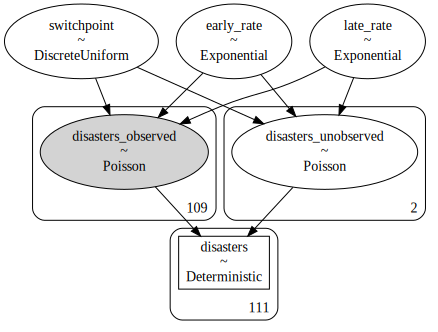

In [6]:
pm.model_to_graphviz(disaster_model)

In [7]:
with disaster_model:
   trace = pm.sample(draws=4000, tune=1000, step=pm.Metropolis(), random_seed=123)

# Note: in PyMC v.5.21, we get a "TypeError", which is resolved by specifying the step method in the sampling function.


Output()

## Visualizing what the Bayesian inference model has determined

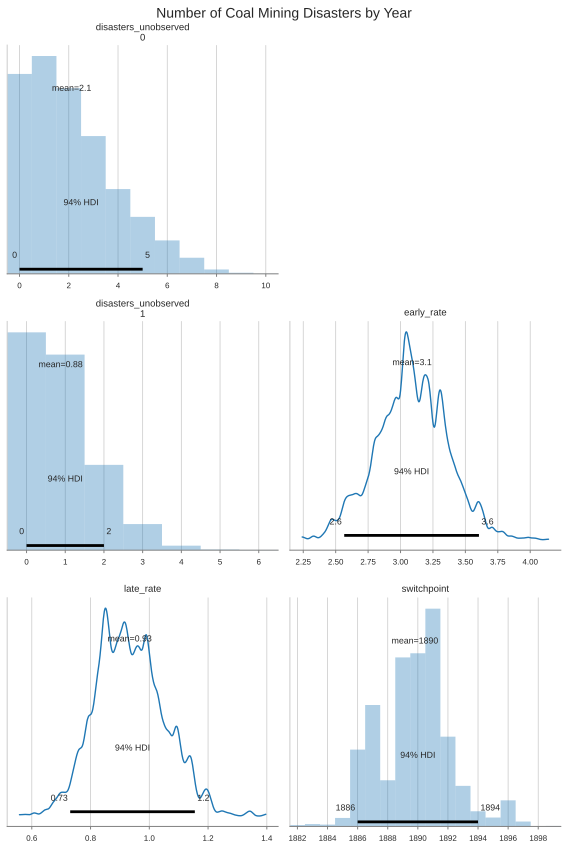

In [8]:
# # Create a figure and axes for the subplots
# fig, axes = plt.subplots(3, 2, figsize=(10, 10))  # 2 rows, 2 columns
# axes = axes.flatten()
# plt.suptitle('Number of Coal Mining Disasters by Year', size=14)

# g = az.plot_posterior(trace, var_names=["switchpoint", "~disasters","~rate"], ax=axes)

# plt.tight_layout()
# sns.despine()""

# Create a figure with a 3x2 grid of subplots
fig, ax = plt.subplots(3, 2, figsize=(8, 12))

# Define the axes for each parameter based on the desired arrangement:
# Top row: switchpoint on the left; leave top right empty.
ax_S = ax[0, 0]
ax_empty = ax[0, 1]  # we'll hide this later

# Second row: disasters_unobserved and disasters_observed side-by-side.
ax_D0 = ax[1, 0]
ax_D1 = ax[1, 1]

# Third row: early_rate and late_rate side-by-side.
ax_E = ax[2, 0]
ax_L = ax[2, 1]

# Arrange the axes in the order corresponding to the variables:
# Order: [S, D0, D1, E, L]
desired_axes = [ax_S, ax_D0, ax_D1, ax_E, ax_L]

# Plot the posterior for the selected variables on the arranged axes.
# Note: We assume that the variables are ordered as:
# "switchpoint", "disasters_unobserved", "disasters_observed", "early_rate", "late_rate"
g = az.plot_posterior(
    trace,
    var_names=["switchpoint", "~disasters"],  # assuming "~disasters" expands to D0 and D1
    ax=desired_axes
)

# Hide the unused (empty) subplot.
ax_empty.set_visible(False)

plt.suptitle('Number of Coal Mining Disasters by Year', size=14)
plt.tight_layout()
sns.despine();

In [9]:
az.summary(trace, var_names=["switchpoint", "~disasters"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
disasters_unobserved[0],2.116,1.832,0.000,5.000,0.066,0.032,713.0,858.0,1.01
disasters_unobserved[1],0.880,0.926,0.000,2.000,0.025,0.020,1392.0,1590.0,1.00
early_rate,3.089,0.273,2.566,3.605,0.010,0.006,818.0,994.0,1.00
late_rate,0.933,0.117,0.731,1.155,0.004,0.003,1091.0,1135.0,1.00
switchpoint,1889.806,2.393,1886.000,1894.000,0.094,0.056,645.0,1213.0,1.01


## Interpreting the Posterior Visualizations and Summary Table

In the cells above, we visualize and summarize the key outputs from our PyMC model for the coal-mining disaster switchpoint analysis. These plots and table provide important insights into our model's estimated parameters.

### Posterior Distributions with `az.plot_posterior()`

The first code block creates grid of subplots, and we use ArviZ’s `plot_posterior()` function to display the posterior distributions of our parameters. In these plots, we are examining the following variables:

- **`switchpoint`**:  
  This parameter represents the point in time when the underlying rate of disasters is inferred to have changed. Its posterior distribution gives us an estimate of when this significant change likely occurred.

- **`disasters_unobserved` and `disasters_observed`**:  
  These variables capture the model's representation of the number of disasters that were, respectively, not directly observed (latent) and directly observed in the data. By comparing their distributions, we can assess how well our model is capturing the underlying process.

- **`early_rate` and `late_rate`**:  
  These represent the estimated average disaster rates before and after the switchpoint, respectively. The posterior distributions for these parameters help us understand the magnitude of change in the disaster rate and provide clues about the potential impact of the change (e.g., due to new safety regulations).

Each bar chart (or density plot) in the grid shows the full posterior distribution for one of these parameters. These plots help us visualize the uncertainty associated with each estimate, giving us a richer understanding than a single point estimate would.

### Summary Table with `az.summary()`

The second code block uses `az.summary()` to generate a table summarizing the posterior distributions of our key variables. This table typically includes:
- **Mean**: The average value of the posterior distribution.
- **Standard Deviation**: A measure of the uncertainty around the mean.
- **Highest Posterior Density Interval (HDI)**: Upper and lower bounds on credible intervals that indicate the range of values within which the parameter is likely to lie.
- Other diagnostics like effective sample size and R-hat values (if applicable) to assess modeling convergence--checking that our model's simulation has run long enough for the estimates to stabilize. In other words, we want to ensure that as the model runs more, its predictions stop changing significantly, giving us confidence that our results are reliable.  These metrics are used in Bayesian modeling.


This summary table provides a concise, numerical overview of our model’s inferences. For example:
- The estimated **`switchpoint`** will give you a clear idea of when the significant change in disaster rates is believed to have occurred.
- The differences between the **`early_rate`** and **`late_rate`** can indicate how drastically the disaster rate changed before and after the switchpoint.
- The comparisons between **`disasters_unobserved`** and **`disasters_observed`** help validate that our model is capturing both the observed data and the underlying latent processes accurately.

### Bringing It All Together

By combining the visual insights from the posterior plots with the detailed numerical summary, we gain a comprehensive view of the model’s performance and the dynamics of the switchpoint phenomenon. This integrated analysis allows us to move beyond a simple trend analysis and start addressing deeper questions:
- **When did the significant change occur?**
- **What is the magnitude of change in the disaster rate?**
- **How do our observed data and model inferences align?**

These outputs set the stage for further investigation into the potential causes behind the observed shift, whether it be changes in legislation, safety protocols, or other external factors.


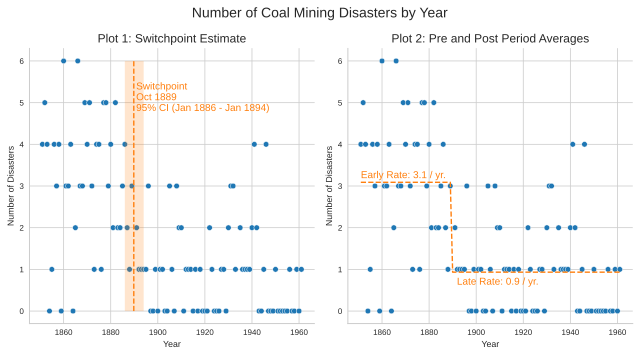

In [10]:
# Represent fractional years as dates (for fun)
def year_fraction_to_date(year_fraction):
    year = int(year_fraction)
    fraction = year_fraction - year

    start_date = datetime.datetime(year, 1, 1)
    days_in_year = (datetime.datetime(year + 1, 1, 1) - start_date).days

    day_of_year = int(fraction * days_in_year) + 1

    return start_date + datetime.timedelta(days=day_of_year - 1)

# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 5))  # 1 row, 2 columns
plt.suptitle('Number of Coal Mining Disasters by Year', size=14)

# Plot 1 (left-hand side): switchpoint
g = sns.scatterplot(disaster_data, ax=axes[0])
g.set_ylabel('Number of Disasters')
g.set_xlabel('Year')
g.set_title('Plot 1: Switchpoint Estimate', size=12)


# Get switchpoint mean and credible interval (highest posterior density)
switchpoint_mean = np.mean(trace['posterior']['switchpoint'].values)
switchpoint_hpd_lo = np.quantile(trace['posterior']['switchpoint'].values,0.05)
switchpoint_hpd_hi = np.quantile(trace['posterior']['switchpoint'].values,0.95)

switchpoint_mean_dt = year_fraction_to_date(switchpoint_mean)
switchpoint_hpd_lo_dt = year_fraction_to_date(switchpoint_hpd_lo)
switchpoint_hpd_hi_dt = year_fraction_to_date(switchpoint_hpd_hi)



# Show estimated switchpoint (mean) as a dotted line
g.vlines(switchpoint_mean,
         disaster_data.min(), disaster_data.max(),
         linestyle='--', color='C1'
         )

# Plot the credible interval (fill within)
g.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                x1=switchpoint_hpd_lo,
                x2=switchpoint_hpd_hi,
                alpha=0.2
                )

g.text(s=f'Switchpoint\n{switchpoint_mean_dt.strftime("%b %Y")}\n95% CI ({switchpoint_hpd_lo_dt.strftime("%b %Y")} - {switchpoint_hpd_hi_dt.strftime("%b %Y")})',
       color='C1',
       x=switchpoint_mean+1, y=disaster_data.max()*0.8
       )



# Plot 2 (left-hand side): Pre and Post Averages

early_rate_mean = np.mean(trace['posterior']['early_rate']).values
late_rate_mean  = np.mean(trace['posterior']['late_rate']).values

h = sns.scatterplot(disaster_data, ax=axes[1])
h.set_ylabel('Number of Disasters')
h.set_xlabel('Year')
h.set_title('Plot 2: Pre and Post Period Averages', size=12)

average_disasters = np.zeros_like(disaster_data.values, dtype="float")
for i, year in enumerate(years):
    idx = year < switchpoint_mean
    average_disasters[i] = np.where(idx, early_rate_mean, late_rate_mean)

h.plot(years, average_disasters, "--", color='C1')

h.text(s=f'Early Rate: {early_rate_mean:0.1f} / yr.',
       color='C1',
       x=np.min(years), y=early_rate_mean+0.1,
       size=10
       )

h.text(s=f'Late Rate: {late_rate_mean:0.1f} / yr.',
       color='C1',
       x=switchpoint_mean + 2, y=late_rate_mean-0.3,
       size=10
       )



plt.tight_layout()
sns.despine()

## Mathematically, what is the difference here?

### Comparing Trend/Regression Models and Switchpoint Models

When we perform a simple trend analysis or regression, we are typically fitting a smooth, continuous function through our data. For example, in a basic linear regression we might assume that the data can be modeled as:
\begin{equation}
y(t) = \beta_0 + \beta_1 t + \epsilon
\end{equation}

Here:
- $y(t)$ is the outcome at time $t$,
- $\beta_0$ is the intercept,
- $\beta_1$ is the slope (the rate of change over time), and
- $\epsilon$ is random noise.

This model fits a single straight line to all the data points, capturing an overall trend.

In contrast, **switchpoint models** are designed to detect and characterize an **abrupt change** in the behavior of the data. Instead of fitting one continuous function to all of the data, a switchpoint model assumes that there is a specific time \( \tau \) where the behavior shifts. One simple way to think about this is to imagine that before and after the switchpoint, the data behave differently. For example, we might model the data as:

\begin{equation}
y(t) =
\begin{cases}
\alpha_1 + \epsilon_1, & \text{if } t < \tau \\
\alpha_2 + \epsilon_2, & \text{if } t \geq \tau
\end{cases}
\end{equation}

In this formulation:
- $\alpha_1$ is the average level (or rate) before the switchpoint,
- $\alpha_2$ is the average level after the switchpoint,
- $\tau$ is the time when the change occurs, and
- $\epsilon_1$ and $\epsilon_2$ represent the random noise in each regime.

More complex switchpoint models can also include trends (e.g., different slopes) before and after the switchpoint:

\begin{equation}
y(t) =
\begin{cases}
\alpha_1 + \beta_1 t + \epsilon_1, & \text{if } t < \tau \\
\alpha_2 + \beta_2 t + \epsilon_2, & \text{if } t \geq \tau
\end{cases}
\end{equation}

### What Is Being Estimated?

- **In Trend/Regression Models:**  
  We estimate the parameters (like $\beta_0$ and $\beta_1)$ that define one continuous function across all the data. This tells us about the overall trend but doesn’t pinpoint when any changes in behavior occur.

- **In Switchpoint Models:**  
  We are estimating not only the parameters of the function in each segment (like $\alpha_1, \beta_1$ for the first segment and $\alpha_2, \beta_2$ for the second) but also the switchpoint $\tau$ — the specific time at which the behavior changes. This approach gives us two pieces of information:
  1. **When did the change occur?** (the value of $\tau$)
  2. **How did the behavior differ before and after the change?** (the parameters for each segment)

In essence, while a regression model fits one smooth line to your data, a switchpoint model fits a **piecewise function**—a function that can have different behaviors in different segments—allowing us to identify and analyze sudden changes in the data.


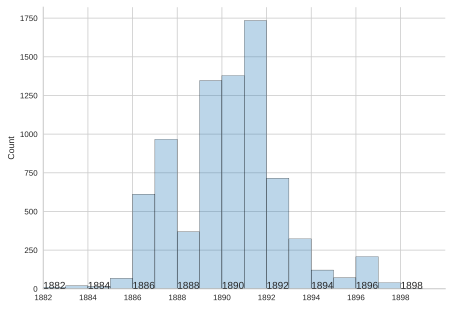

In [11]:
g = sns.histplot(trace['posterior']['switchpoint'].values.flatten(),
                 binwidth=1,
                 alpha=0.3
                 )

# Bins are a little weird--let's set them explictly
tl = np.arange(1882, 1900, 2)
tl_list = []
tl_values = []
for t in tl:
    tl_item = plt.text(t,0,f'{t}')
    tl_values.append(t)
    tl_list.append(tl_item)

g.axes.xaxis.set_ticks(tl_values)
g.axes.xaxis.set_ticklabels(tl_list,minor=False)
#g.set_xticklabels(tl_list, minor=False)
g.set_xlim([1882,1900])

plt.tight_layout()
sns.despine()
plt.show()

In [12]:
%load_ext watermark

%watermark --iversions

arviz     : 0.21.0
seaborn   : 0.13.2
pymc      : 5.21.1
pandas    : 2.2.2
numpy     : 2.0.2
watermark : 2.5.0
matplotlib: 3.10.0
IPython   : 7.34.0

